# Web Scraping 

O objetivo desta análise é realizar coleta e organização de dados por meio de web scraping.

A proposta do projeto pode ser encontrada neste link: http://bit.ly/3Q64W7m

A ideia consiste em extrair informações específicas dos livros, incluindo o título, categoria, avaliação em estrelas, preço e disponibilidade em estoque.


In [1]:
# importes para coleta de dados da web
import requests
from bs4 import BeautifulSoup
import pandas as pd

#### Aqui estamos definindo qual página iremos coletar os dados e também testando se a conexão é efetiva.

In [2]:
url = "https://books.toscrape.com/"
response = requests.get(url)
if response.status_code == 200:
    print('Conexão foi um sucesso')
else:
    print('Conexão falhou')


Conexão foi um sucesso


#### O código abaixo irá navegar por cada pagina de todos os livros e coletar as informções salvando em um dicionário.

In [3]:
books_data = []
# Observacão importante, para que o código funcione corretamente, vc deve usar a base url abaixo, desta maneira o html entende
# que você não está criando uma nova pagina e sim navegando através das tag html.
# Essa abordagem é especialmente útil quando você precisa coletar dados de muitas páginas com estruturas semelhantes,
# pois permite automatizar o processo de obtenção de URLs e torna o web scraping mais eficiente e escalável.
baseurl = 'https://books.toscrape.com/catalogue/'

# Loop para as 50 paginas do site
# Cuidado ao executar o loop, seu computador pode demorar um pouco, sugiro colocar umas 5 paginas para testar primeiramente. 
for num_pag in range(1,51):
    url = baseurl + f'page-{num_pag}.html'
    response = requests.get(url)
    soup = BeautifulSoup(response.content,'html.parser')
    
    # Buscando todos os livros através da tag h3
    books = soup.find_all('h3')
    # Neste Loop for, estamos navegando para cada pagina dos livros e colentando todas as informações propostas nesse desafio
    for book in books:
        # Acessando o link do primeiro livro
        book_url = book.find('a')['href']
        #Buscando a base url e adicionando o link de cada livro individualmente
        book_response = requests.get(baseurl + book_url)
        book_soup = BeautifulSoup(book_response.content,'html.parser')
        # Extraindo os dados: Titulo, Categoria, Estrelas, Preço e Avalaiações
        title = book_soup.find('h1').text
        category = book_soup.find('ul',class_='breadcrumb').find_all('a')[2].text.strip() 
        rating = book_soup.find('p',class_='star-rating')['class'][1] 
        price = book_soup.find('p',class_='price_color').text.strip()
        availability = book_soup.find('p',class_='availability').text.strip()
    
        #Adicionando cada livro em uma lista de dicionários
        books_data.append({'Titulo': title, 'Categoria': category, 'Estrelas': rating, 'Preco': price, 'Avaliacoes': availability})

In [4]:
# Criando Data Frame do pandas
df = pd.DataFrame(books_data)
df.head()

,Titulo,Categoria,Estrelas,Preco,Avaliacoes
0,A Light in the Attic,Poetry,Three,£51.77,In stock (22 available)
1,Tipping the Velvet,Historical Fiction,One,£53.74,In stock (20 available)
2,Soumission,Fiction,One,£50.10,In stock (20 available)
3,Sharp Objects,Mystery,Four,£47.82,In stock (20 available)
4,Sapiens: A Brief History of Humankind,History,Five,£54.23,In stock (20 available)


In [5]:
# Criando novo DF seperando a coluna avaliacoes em duas partes Disponibilidade e Analise
novo_df = df
novo_df[['Disponibilidade', 'Analise']] = df['Avaliacoes'].str.extract(r'([^\(]*)\((\d+)')

# Removendo espaços em branco no início e no final das colunas
novo_df['Disponibilidade'] = novo_df['Disponibilidade'].str.strip()
novo_df['Analise'] = novo_df['Analise'].str.strip()

In [6]:
# Removendo a coluna avaliações
novo_df = novo_df.drop(columns=['Avaliacoes'])

In [7]:
# Transformando os números descritos em números inteiros
mapeando_estrelas = { 'One': '1','Two': '2', 'Three': '3', 'Four': '4', 'Five': '5'}
novo_df['Estrelas'] = novo_df['Estrelas'].map(mapeando_estrelas)

In [8]:
# Removendo o caracter £ da coluna preço
novo_df['Preco'] = novo_df['Preco'].str.replace('£', '')

In [9]:
# Validando para ver se deu certo
novo_df.head()

,Titulo,Categoria,Estrelas,Preco,Disponibilidade,Analise
0,A Light in the Attic,Poetry,3,51.77,In stock,22
1,Tipping the Velvet,Historical Fiction,1,53.74,In stock,20
2,Soumission,Fiction,1,50.10,In stock,20
3,Sharp Objects,Mystery,4,47.82,In stock,20
4,Sapiens: A Brief History of Humankind,History,5,54.23,In stock,20


## Nesta etapa, ocorre a inserção de todas as informações coletadas em um banco de dados local. Utilizou-se o código abaixo para criar o banco de dados no PostgreSQL:

#### Antes de executar o código abaixo, certifique-se que você já criou o schema chamado "bookscrap".

```sql
CREATE TABLE bookscrap.livros (
    id_livros SERIAL PRIMARY KEY,
    titulo VARCHAR(350) NOT NULL,
    categoria VARCHAR(100) NOT NULL,
    estrelas INTEGER NOT NULL,
    precos NUMERIC(5) NOT NULL,
    disponibilidade CHAR(50) NOT NULL,
    analise INTEGER NOT NULL
);
```


No código a seguir, utilizaremos o pacote psycopg2 para estabelecer a conexão com nosso banco de dados local e submeter os dados a ele. Para que a conexão ocorra corretamente, é necessário que você insira as informações específicas do seu banco de dados:

In [10]:
import psycopg2

# Estabelencendo conexão com banco de dados local
try:
    connection = psycopg2.connect(
        host="localhost",      
        database="dbscraping",      
        user="scraping",     
        password="scraping123"    
    )
    print("Conexão bem-sucedida!")

    # Criar um objeto de cursor para executar comandos SQL
    cursor = connection.cursor()

    # Inserir dados do DataFrame "novo_df" na tabela "livros" no schema "bookscrap"
    try:
        for _, row in novo_df.iterrows():
            insert_query = "INSERT INTO bookscrap.livros (titulo, categoria, estrelas, precos, disponibilidade, analise) VALUES (%s, %s, %s, %s, %s, %s)"
            cursor.execute(insert_query, tuple(row))

        # Commit das alterações no banco de dados
        connection.commit()
        print("Inserção bem-sucedida!")

    except psycopg2.Error as e:
        print("Erro ao executar o comando SQL:", e)

    finally:
        # Fechar o cursor e a conexão ao final das operações
        cursor.close()
        connection.close()

except psycopg2.Error as e:
    print("Erro ao conectar:", e)


Conexão bem-sucedida!
Inserção bem-sucedida!


#### O resultado em seu banco deve ser semelhante a este:



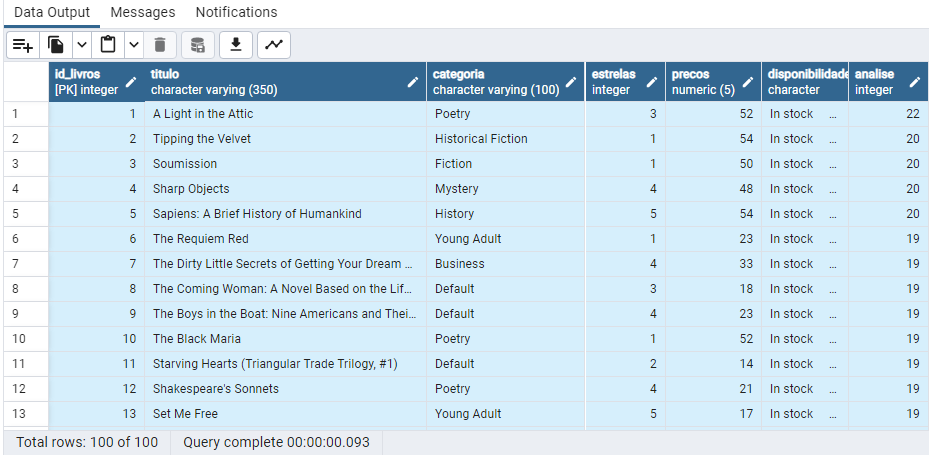

#### Considerações finais

Certamente, podemos realizar algumas melhorias adicionais para tornar o código mais robusto e lidar com possíveis falhas de conexão e páginas não encontradas durante o web scraping.

Agradeço desde-ja qualquer feedback positivo. 